<a href="https://colab.research.google.com/github/marcio-costa/stock_prediction/blob/master/HW_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from time import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [4]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("GOOGL", start="2019-01-01").reset_index()
df_full.to_csv('GOOGL.csv',index=False)
print(df_full.head())
print(df_full.shape)

[*********************100%***********************]  1 of 1 downloaded
        Date         Open         High  ...        Close    Adj Close   Volume
0 2019-01-02  1027.199951  1060.790039  ...  1054.680054  1054.680054  1593400
1 2019-01-03  1050.670044  1066.260010  ...  1025.469971  1025.469971  2098000
2 2019-01-04  1042.560059  1080.000000  ...  1078.069946  1078.069946  2301100
3 2019-01-07  1080.969971  1082.699951  ...  1075.920044  1075.920044  2372300
4 2019-01-08  1086.000000  1093.349976  ...  1085.369995  1085.369995  1770700

[5 rows x 7 columns]
(169, 7)


In [5]:
df_full.describe()

,Open,High,Low,Close,Adj Close,Volume
count,169.000000,169.000000,169.000000,169.000000,169.000000,1.690000e+02
mean,1149.235620,1158.863018,1139.570062,1150.084614,1150.084614,1.610370e+06
std,53.909488,53.793856,54.663356,54.424247,54.424247,8.107277e+05
min,1027.199951,1050.000000,1022.369995,1025.469971,1025.469971,7.076000e+05
25%,1110.319946,1118.000000,1100.500000,1107.300049,1107.300049,1.173000e+06
50%,1146.729980,1154.000000,1138.250000,1148.520020,1148.520020,1.430800e+06
75%,1190.630005,1200.199951,1181.760010,1190.530029,1190.530029,1.765400e+06
max,1280.510010,1296.969971,1271.709961,1296.199951,1296.199951,6.658900e+06


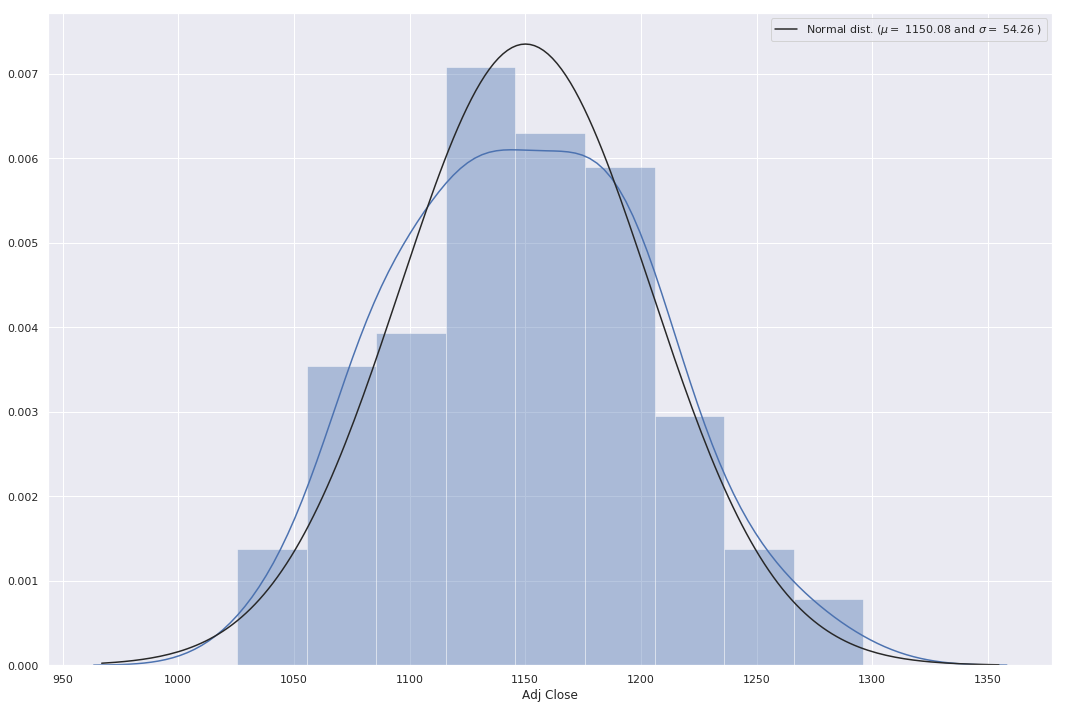

In [6]:
# Histogram on the target Adj Close
plt.subplots(figsize=(18,12))
sns.distplot(df_full['Adj Close'], fit=stats.norm)

# Add parameters
(mu, sigma) = stats.norm.fit(df_full['Adj Close'])

# Plotting
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

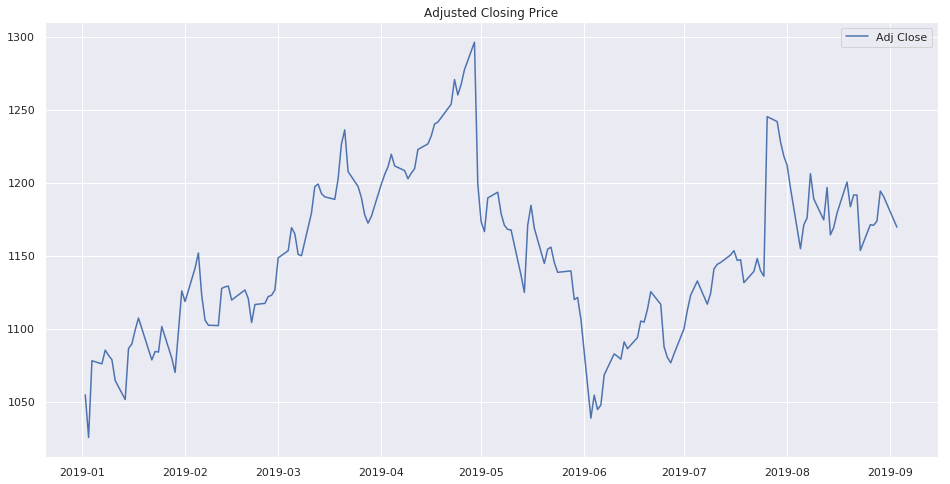

In [7]:
#Ploting
fig = plt.figure(figsize = (16,8))
plt.plot(df_full['Date'],df_full['Adj Close'])
plt.title('Adjusted Closing Price')
plt.legend()
plt.show()

In [8]:
# The variables 'Open', 'High', 'Low', 'Close', 'Volume' will be used to predict the target (Adj Close)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df_full[features]
print(X.head())
print(X.shape)

          Open         High          Low        Close   Volume
0  1027.199951  1060.790039  1025.280029  1054.680054  1593400
1  1050.670044  1066.260010  1022.369995  1025.469971  2098000
2  1042.560059  1080.000000  1036.859985  1078.069946  2301100
3  1080.969971  1082.699951  1062.640015  1075.920044  2372300
4  1086.000000  1093.349976  1068.349976  1085.369995  1770700
(169, 5)


In [9]:
# Model will predict 'Adj Close' value
y = df_full['Adj Close'].values
print(y[:5])
print(y.shape)

[1054.680054 1025.469971 1078.069946 1075.920044 1085.369995]
(169,)


In [10]:
# split data into training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 40)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(135, 5)
(135,)
(34, 5)
(34,)


In [0]:
#Define RMSE (Root Mean Square Error) to evaluate the models
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [0]:
#Define the pipeline 

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Measure the time to create the model
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    
    # Calculating the time took to create the model
    results['train_time'] = end - start
        
    # Measure the time to predict
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    end = time() # Get end time
    
    # Calculating the time took to predict
    results['pred_time'] = end - start
            
    # RMSE of the train dataset
    results['rmse_train'] = rmse_cv_train(learner).mean()

    # RMSE of the test dataset
    results['rmse_test'] = rmse_cv_test(learner).mean()
	
    # Score and time spent
    print(f"The Model {learner.__class__.__name__} took {results['train_time']} to create the model and {results['pred_time']} to predict. The train score is {results['rmse_train']} and test score is {results['rmse_test']}")
    
    # Return do resultados
    return results

In [0]:
# Starting the models
clf_1 = linear_model.Lasso(alpha=0.1, random_state = 40)
clf_2 = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000, n_jobs=-1)
clf_3 = DecisionTreeRegressor(random_state=40)
clf_4 = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=40)

In [14]:
# Running the models 
results = {}
for clf in [clf_1, clf_2, clf_3, clf_4]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

The Model Lasso took 0.006463527679443359 to create the model and 0.003128528594970703 to predict. The train score is 0.018720652924685197 and test score is 0.07471585855165987
[02:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:23] WARNING: /workspace/src/objective/regression_obj.c

In [15]:
df_performance = pd.DataFrame(results)
df_performance

,Lasso,XGBRegressor,DecisionTreeRegressor,RandomForestRegressor
pred_time,0.003129,0.002242,0.000971,0.103479
rmse_test,0.074716,9.528830,10.707475,7.544703
rmse_train,0.018721,4.151917,5.307540,3.951642
train_time,0.006464,0.163808,0.002298,0.143746


In [16]:
#Best model based on RMSE - Test dataset
smallest_rmse = df_performance.loc['rmse_test'].min()
best_model = df_performance.loc['rmse_test'] == smallest_rmse
best_model

Lasso                     True
XGBRegressor             False
DecisionTreeRegressor    False
RandomForestRegressor    False
Name: rmse_test, dtype: bool

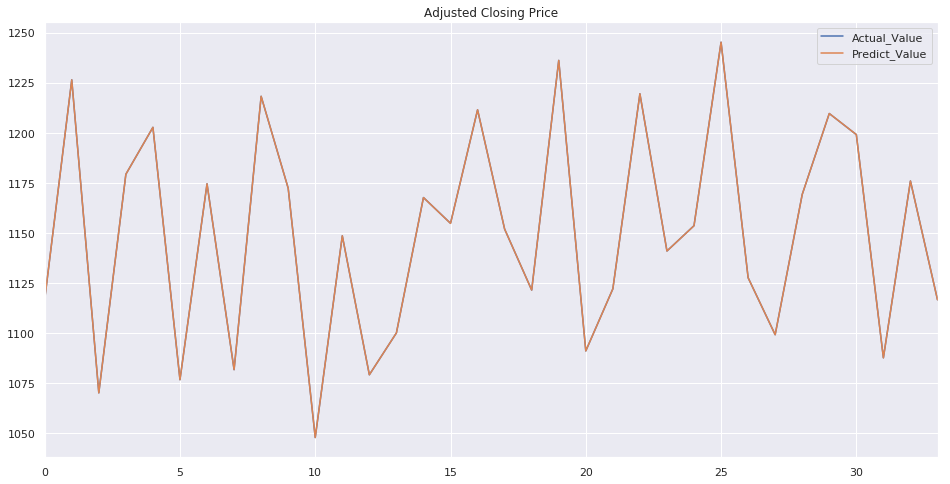

In [24]:
# Plotting the Real and Predict values
y_pred_test = clf_1.predict(X_test)
df_plot = pd.DataFrame({'Actual_Value': y_test.flatten(), 'Predict_Value': y_pred_test.flatten()})
df_plot.plot(figsize=(16,8), title='Adjusted Closing Price', grid=True)